In [49]:
from numpy import *
from numpy.polynomial import polynomial as pl
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits



file = open('1x9n.pdb', 'r')
count = 0
xs = []
ys = []
zs = []
while True:


    line = file.readline()

    if not line:
        break
    a = line.split()
    b = 0


    if a[-1] == 'P':
        if a[0] == "ATOM":
            xs.append(a[-6])
            ys.append(a[-5])
            zs.append(a[-4])




print(len(zs))
print(zs)
print(len(ys))
print(ys)
print(len(xs))
print(xs)

fig = plt.figure()
ax = plt.axes(projection='3d')
for x in xs:
    y = ys[xs.index(x)]
    y = float(y)
    z = zs[xs.index(x)]
    z = float(z)
    x = float(x)
    ax.scatter(x, y, z, c = "blue")
ax.set_title("DNA Representation")
plt.show()

37
['33.294', '34.051', '37.454', '43.291', '48.513', '50.025', '49.487', '45.935', '40.075', '37.116', '39.372', '41.620', '46.977', '53.990', '59.700', '63.806', '63.697', '60.418', '47.288', '46.014', '48.501', '53.192', '55.666', '57.191', '57.129', '52.916', '46.694', '41.073', '34.812', '32.354', '32.064', '35.023', '40.739', '46.170', '50.012', '52.004', '48.364']
37
['7.422', '12.484', '17.125', '21.004', '23.151', '25.188', '24.494', '28.402', '30.620', '41.689', '45.942', '50.027', '53.007', '54.335', '54.430', '54.229', '54.513', '55.604', '64.311', '58.622', '53.065', '48.377', '43.747', '40.833', '40.545', '39.222', '38.451', '37.418', '35.263', '30.104', '24.550', '20.277', '16.912', '14.673', '12.479', '12.051', '8.682']
37
['32.715', '28.522', '25.611', '25.822', '29.513', '35.585', '42.467', '46.551', '49.202', '47.565', '43.243', '39.697', '37.849', '37.008', '40.183', '45.429', '51.749', '57.386', '49.399', '52.856', '55.091', '55.721', '51.940', '46.266', '39.604', 

In [51]:
x = ['33.294', '34.051', '37.454', '43.291', '48.513', '50.025', '49.487', '45.935', '40.075', '37.116', '39.372', '41.620', '46.977', '53.990', '59.700', '63.806', '63.697', '60.418', '47.288', '46.014', '48.501', '53.192', '55.666', '57.191', '57.129', '52.916', '46.694', '41.073', '34.812', '32.354', '32.064', '35.023', '40.739', '46.170', '50.012', '52.004', '48.364']
y = ['7.422', '12.484', '17.125', '21.004', '23.151', '25.188', '24.494', '28.402', '30.620', '41.689', '45.942', '50.027', '53.007', '54.335', '54.430', '54.229', '54.513', '55.604', '64.311', '58.622', '53.065', '48.377', '43.747', '40.833', '40.545', '39.222', '38.451', '37.418', '35.263', '30.104', '24.550', '20.277', '16.912', '14.673', '12.479', '12.051', '8.682']
z = ['32.715', '28.522', '25.611', '25.822', '29.513', '35.585', '42.467', '46.551', '49.202', '47.565', '43.243', '39.697', '37.849', '37.008', '40.183', '45.429', '51.749', '57.386', '49.399', '52.856', '55.091', '55.721', '51.940', '46.266', '39.604', '34.420', '32.818', '31.529', '31.931', '35.356', '38.856', '43.698', '44.476', '41.885', '36.778', '30.191', '25.295']

x = x[0:19]
print(x)
print(len(x))
y = y[0:19]
print(y)
print(len(y))
z = z[0:19]
print(z)
print(len(z))

['33.294', '34.051', '37.454', '43.291', '48.513', '50.025', '49.487', '45.935', '40.075', '37.116', '39.372', '41.620', '46.977', '53.990', '59.700', '63.806', '63.697', '60.418', '47.288']
19
['7.422', '12.484', '17.125', '21.004', '23.151', '25.188', '24.494', '28.402', '30.620', '41.689', '45.942', '50.027', '53.007', '54.335', '54.430', '54.229', '54.513', '55.604', '64.311']
19
['32.715', '28.522', '25.611', '25.822', '29.513', '35.585', '42.467', '46.551', '49.202', '47.565', '43.243', '39.697', '37.849', '37.008', '40.183', '45.429', '51.749', '57.386', '49.399']
19


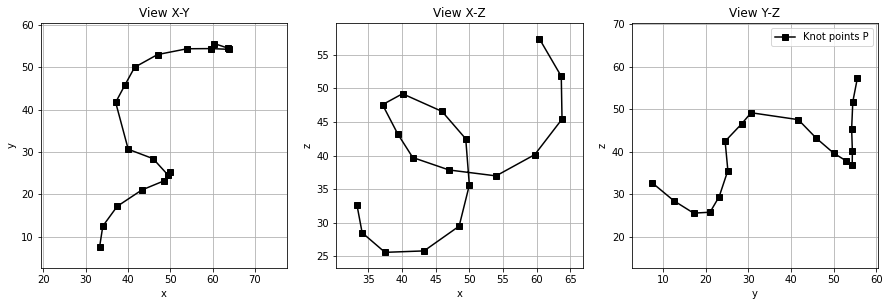

In [52]:
%matplotlib inline

#--- Generate y,z coords from given x coords
def generate_yz_coords(x):
    y = -0.5 * x**2 - 0.3 * x + 5
    z = 0.1 * x**3 + 5
    return y, z

#--- Generate and store knot points in matrix P
x = ['33.294', '34.051', '37.454', '43.291', '48.513', '50.025', '49.487', '45.935', '40.075', '37.116', '39.372', '41.620', '46.977', '53.990', '59.700', '63.806', '63.697', '60.418']
y = ['7.422', '12.484', '17.125', '21.004', '23.151', '25.188', '24.494', '28.402', '30.620', '41.689', '45.942', '50.027', '53.007', '54.335', '54.430', '54.229', '54.513', '55.604']
z = ['32.715', '28.522', '25.611', '25.822', '29.513', '35.585', '42.467', '46.551', '49.202', '47.565', '43.243', '39.697', '37.849', '37.008', '40.183', '45.429', '51.749', '57.386']

n = len(x)

P = zeros([n,3])
P[:,0] = x
P[:,1] = y
P[:,2] = z

#--- Add some random noise to knot points excl. end-points
P[range(1,n-1),:] += random.normal(size=(n-2,3)) * 0.02

#--- Calculate some points to display the generating curve
#x_gen = linspace(-2, 2, 50)
#y_gen, z_gen = generate_yz_coords(x_gen)
#P_gen = zeros([len(x_gen),3])
#P_gen[:,0] = x_gen
#P_gen[:,1] = y_gen
#P_gen[:,2] = z_gen

#--- Plot
f, ax = subplots(1, 3, figsize=(15,4.5))
i = 0
#ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,1], 'ks-', label='Knot points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 1
#ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,2], 'ks-', label='Knot points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 2
#ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,1], P[:,2], 'ks-', label='Knot points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()

In [53]:
def uniform_param(P):
    u = linspace(0, 1, len(P))
    return u
    
def chordlength_param(P):
    u = generate_param(P, alpha=1.0)
    return u
    
def centripetal_param(P):
    u = generate_param(P, alpha=0.5)
    return u
    
def generate_param(P, alpha):
    n = len(P)
    u = zeros(n)
    u_sum = 0
    for i in range(1,n):
        u_sum += linalg.norm(P[i,:]-P[i-1,:])**alpha
        u[i] = u_sum
    
    return u/max(u)

In [54]:
#-------------------------------------------------------------------------------
# Find Minimum by Golden Section Search Method
# - Return x minimizing function f(x) on interval a,b
#-------------------------------------------------------------------------------
def find_min_gss(f, a, b, eps=1e-4):
    
    # Golden section: 1/phi = 2/(1+sqrt(5))
    R = 0.61803399
    
    # Num of needed iterations to get precision eps: log(eps/|b-a|)/log(R)
    n_iter = int(ceil(-2.0780869 * log(eps/abs(b-a))))
    c = b - (b-a)*R
    d = a + (b-a)*R

    for i in range(n_iter):
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b-a)*R
        d = a + (b-a)*R

    return (b+a)/2

In [55]:
def iterative_param(P, u, fxcoeff, fycoeff, fzcoeff, fig_ax):
    
    global iter_i, plt_color
    u_new = u.copy()
    f_u = zeros(3)

    #--- Calculate approx. error s(u) related to point P_i
    def calc_s(u):
        f_u[0] = pl.polyval(u, fxcoeff)
        f_u[1] = pl.polyval(u, fycoeff)
        f_u[2] = pl.polyval(u, fzcoeff)

        s_u = linalg.norm(P[i]-f_u)
        return s_u
    
    #--- Find new values u that locally minimising the approximation error (excl. fixed end-points)
    for i in range(1, len(u)-1):
        
        #--- Find new u_i minimising s(u_i) by Golden search method
        u_new[i] = find_min_gss(calc_s, u[i-1], u[i+1])
        
        #--- Sample some values bewteen u[i-1] and u[i+1] to plot graph
        u_samp = linspace(u[i-1], u[i+1], 25)
        
        x = pl.polyval(u_samp, fxcoeff)
        y = pl.polyval(u_samp, fycoeff)
        z = pl.polyval(u_samp, fzcoeff)

        residual = P[i] - array([x,y,z]).T
        s_u_samp = [linalg.norm(residual[j]) for j in range(len(u_samp))]
        
        #--- Plot error to given axes
        fig_ax.plot(u_samp, s_u_samp, color=plt_color[iter_i], alpha=plt_alpha)
        fig_ax.plot(u_new[i], calc_s(u_new[i]), 'o', color=plt_color[iter_i], alpha=plt_alpha)
        
    return u_new

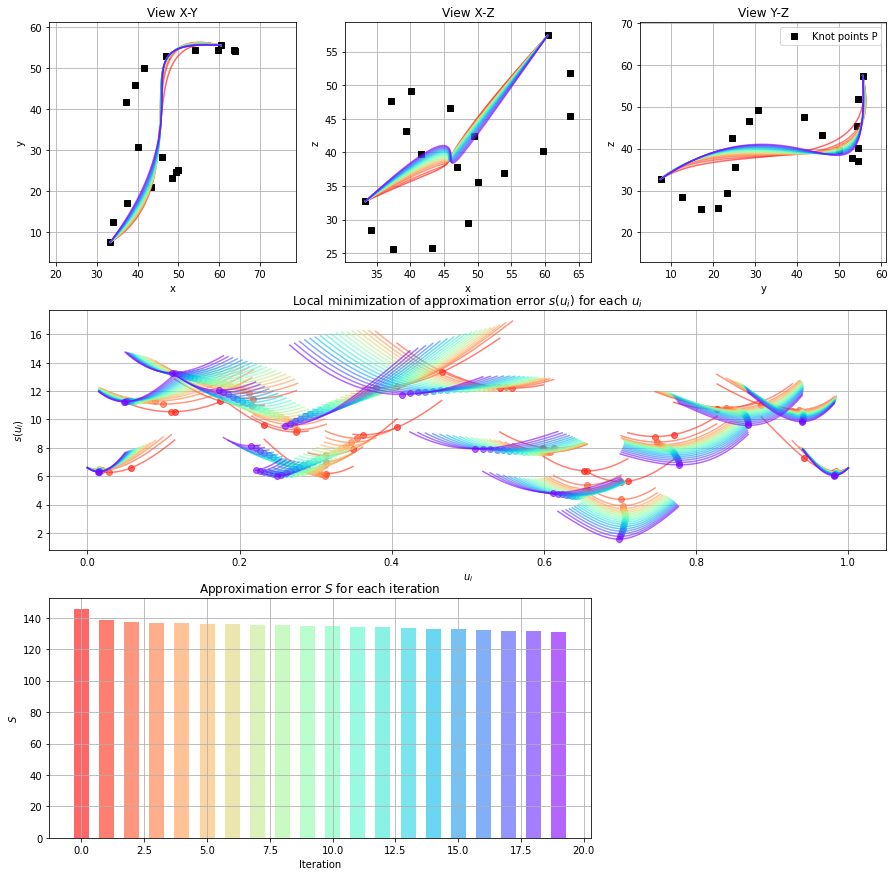

In [60]:
%matplotlib inline

#-------------------------------------------------------------------------------
# Options for the approximation method
#-------------------------------------------------------------------------------
polydeg = 3           # Degree of polygons of parametric curve
w = ones(n)           # Set weights for knot points
w[0] = w[-1] = 1e6
max_iter = 20         # Max. number of iterations
eps = 1e-3
plt_alpha = 0.6
plt_color = cm.rainbow(linspace(1,0,max_iter))

#-------------------------------------------------------------------------------
# Init variables
#-------------------------------------------------------------------------------
f_u = zeros([n,3])
uu = linspace(0,1,100)
f_uu = zeros([len(uu),3])
S_hist = []

#-------------------------------------------------------------------------------
# Init figures
#-------------------------------------------------------------------------------
fig = figure(figsize=(15,15))
figshape = (3,3)
ax = [None]*5
ax[0] = subplot2grid(figshape, loc=(0,0))
ax[1] = subplot2grid(figshape, loc=(0,1))
ax[2] = subplot2grid(figshape, loc=(0,2))
ax[3] = subplot2grid(figshape, loc=(1,0), colspan=3)
ax[4] = subplot2grid(figshape, loc=(2,0), colspan=2)
i = 0
#ax[i].plot(P_gen[:,0], P_gen[:,1], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,1], 'ks', label='Knot points P')
ax[i].set_title('View X-Y')
ax[i].set_xlabel('x'); ax[i].set_ylabel('y');
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 1
#ax[i].plot(P_gen[:,0], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,0], P[:,2], 'ks', label='Knot points P')
ax[i].set_title('View X-Z')
ax[i].set_xlabel('x'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].grid()
i = 2
#ax[i].plot(P_gen[:,1], P_gen[:,2], 'y-', lw=2 ,label='Generating Curve')
ax[i].plot(P[:,1], P[:,2], 'ks', label='Knot points P')
ax[i].set_title('View Y-Z')
ax[i].set_xlabel('y'); ax[i].set_ylabel('z'); 
ax[i].set_aspect('equal', 'datalim')
ax[i].margins(.1, .1)
ax[i].legend()
ax[i].grid()
i = 3
ax[i].set_title('Local minimization of approximation error $s(u_i)$ for each $u_i$')
ax[i].set_xlabel('$u_i$'); ax[i].set_ylabel('$s(u_i)$');
ax[i].grid()
i = 4
ax[i].set_title('Approximation error $S$ for each iteration')
ax[i].set_xlabel('Iteration'); ax[i].set_ylabel('$S$');
ax[i].grid()

#-------------------------------------------------------------------------------
# Compute the iterative approximation
#-------------------------------------------------------------------------------
for iter_i in range(max_iter):

    #--- Initial or iterative parametrization
    if iter_i == 0:
        #u = uniform_param(P)
        #u = chordlength_param(P)
        u = centripetal_param(P)
    else:
        u = iterative_param(P, u, fxcoeff, fycoeff, fzcoeff, ax[3])
    
    #--- Compute polynomial approximations and get their coefficients
    fxcoeff = pl.polyfit(u, P[:,0], polydeg, w=w)
    fycoeff = pl.polyfit(u, P[:,1], polydeg, w=w)
    fzcoeff = pl.polyfit(u, P[:,2], polydeg, w=w)
    
    #--- Calculate function values f(u)=(fx(u),fy(u),fz(u))
    f_u[:,0] = pl.polyval(u, fxcoeff)
    f_u[:,1] = pl.polyval(u, fycoeff)
    f_u[:,2] = pl.polyval(u, fzcoeff)
    
    #--- Calculate fine values for ploting
    f_uu[:,0] = pl.polyval(uu, fxcoeff)
    f_uu[:,1] = pl.polyval(uu, fycoeff)
    f_uu[:,2] = pl.polyval(uu, fzcoeff)

    #--- Print plots
    hp = ax[0].plot(f_uu[:,0], f_uu[:,1], color=plt_color[iter_i], alpha=plt_alpha)
    hp = ax[1].plot(f_uu[:,0], f_uu[:,2], color=plt_color[iter_i], alpha=plt_alpha)
    hp = ax[2].plot(f_uu[:,1], f_uu[:,2], color=plt_color[iter_i], alpha=plt_alpha)
    
    #--- Errors of init parametrization
    if iter_i == 0:
        for i in range(1, len(u)-1):
            ax[3].plot(u[i], linalg.norm(P[i]-f_u[i]), 'o', color=plt_color[iter_i], alpha=plt_alpha)
    
    #--- Total error of approximation S for iteration i
    S = 0
    for j in range(len(u)):
        S += w[j] * linalg.norm(P[j] - f_u[j])
    
    #--- Add bar of approx. error
    ax[4].bar(iter_i, S, width=0.6, color=plt_color[iter_i], alpha=plt_alpha)
    S_hist.append(S)
    
    #--- Stop iterating if change in error is lower than desired condition
    if iter_i > 0:
        S_change = S_hist[iter_i-1] / S_hist[iter_i] - 1
        #print('iteration:%3i, approx.error: %.4f (%f)' % (iter_i, S_hist[iter_i], S_change))
        if S_change < eps:
            break

In [61]:
%matplotlib

#-------------------------------------------------------------------------------
# - Make axes of 3D plot to have equal scales
# - This is a workaround to Matplotlib's set_aspect('equal') and axis('equal')
#   which were not working for 3D
#-------------------------------------------------------------------------------
def set_axes_equal_3d(ax):
    limits = array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    spans = abs(limits[:,0] - limits[:,1])
    centers = mean(limits, axis=1)
    radius = 0.5 * max(spans)
    ax.set_xlim3d([centers[0]-radius, centers[0]+radius])
    ax.set_ylim3d([centers[1]-radius, centers[1]+radius])
    ax.set_zlim3d([centers[2]-radius, centers[2]+radius])

#--- 3D Plot
fig = figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1,projection='3d')

#ax.plot(*P_gen.T, color='y', lw=4, label='Generating Curve')
ax.plot(*P.T, color='k', ls='--', marker='s', label='Knot points P')
ax.plot(*f_uu.T, color='b', ls='-', lw=3, label='Approximation Curve')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
#ax.set_aspect('equal', 'datalim')
set_axes_equal_3d(ax)

Using matplotlib backend: QtAgg
